# Text Mining


In [1]:
import multiprocessing

import nltk
import pandas as pd
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.lm import MLE
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')  # omw = open multilingual wordnet
stopword_list = set(stopwords.words('english'))
reg_tokenizer = nltk.RegexpTokenizer(r"\w+")  # tokenizes and removes punctuation at the same time
wordnet_lemmatizer = WordNetLemmatizer();

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Data Loading and Preprocessing

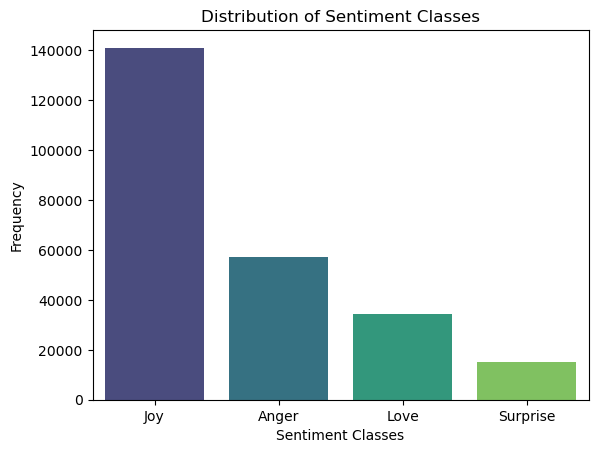

/tmp/ipykernel_252/500619093.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  undersampled_emotions_df = grouped_data.apply(lambda x: x.iloc[:k, :]).reset_index(drop=True)


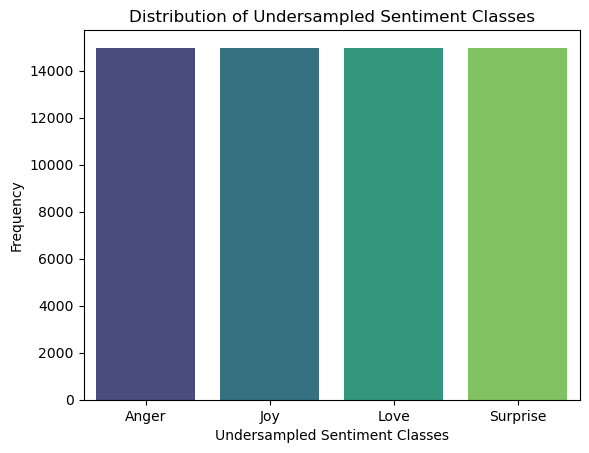

The number of entries for each sentiment class is: 14972


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

emotions_df = pd.read_csv("text_mining/emotions.csv")

sentiment_counts = emotions_df['label'].value_counts()

sns.barplot(x = sentiment_counts.index, y = sentiment_counts.values, palette= 'viridis', hue = sentiment_counts.index, legend = False)

plt.xlabel('Sentiment Classes')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Classes')
plt.savefig('Sentiment_Distribution.png', format='png')
plt.show()

grouped_data = emotions_df.groupby('label')

k = sentiment_counts['Surprise']

undersampled_emotions_df = grouped_data.apply(lambda x: x.iloc[:k, :], include_groups = True).reset_index(drop=True)

undersampled_sentiment_counts = undersampled_emotions_df['label'].value_counts()

sns.barplot(x = undersampled_sentiment_counts.index, y = undersampled_sentiment_counts.values, palette= 'viridis', hue = sentiment_counts.index, legend = False)

plt.xlabel('Undersampled Sentiment Classes')
plt.ylabel('Frequency')
plt.title('Distribution of Undersampled Sentiment Classes')
plt.savefig('Undersampled_Sentiment_Distribution.png', format='png')
plt.show()

print(f'The number of entries for each sentiment class is: {k}')

In [3]:
   
def preprocess(doc):
    reg_tokens = reg_tokenizer.tokenize(doc) #producing a list with tokens
    
    preprocessed_tokens = []
    
    for token in reg_tokens: #the loop converts the tokens to lower case, removes stopwords and transforms the tokens to their lemmas then joins them to a single string
        low_token = token.lower()
        if low_token not in stopword_list:
            preprocessed_tokens.append(wordnet_lemmatizer.lemmatize(low_token))
            
    final_doc = ' '.join(preprocessed_tokens)
    
    return final_doc 
    
    

In [4]:
#function which counts the tokens for a given corpus and a given column
def token_count(corpus, column_name):
    total_tokens = corpus[column_name].apply(lambda text: len(reg_tokenizer.tokenize(text))).sum()
    return total_tokens

#applying preprocessing to undersampled_emotions_df:
undersampled_emotions_df['preprocessed_text'] = undersampled_emotions_df['text'].apply(lambda doc: preprocess(doc))

#token counts before and after preprocessing
token_count_before = token_count(undersampled_emotions_df, 'text')
token_count_after = token_count(undersampled_emotions_df, 'preprocessed_text')

print(f'Number of tokens before preprocessing: {token_count_before}')
print(f'Number of tokens after preprocessing: {token_count_after}')

Number of tokens before preprocessing: 1187786
Number of tokens after preprocessing: 575838


In [5]:
train_df, test_df = train_test_split(
undersampled_emotions_df,
test_size = 0.2,
stratify = undersampled_emotions_df['label'],
random_state = 12345)

print(f'Train data size: {len(train_df)}')
print(f'Test data size: {len(test_df)}')

with pd.option_context('display.max_colwidth', None):
    print(train_df['text'].head(3))
    print(test_df['text'].head(3))

Train data size: 47910
Test data size: 11978
16078                                                         my parents came to visit me
1834     ill state that i am angry at myself for feeling so out of control and so hostile
17378                                     i feel calm complete and whole after i meditate
Name: text, dtype: object
32491    i feel blessed each day with what i have been given and i understand that these are first world problems i have a roof over my head ample food and freedom and yet
41565                                                             i feel like a loser because all the guys i have liked so far aren t ready for a relationship what do i do
24389                                                                                                                            i had a funny feeling when i accepted them
Name: text, dtype: object


## Bag-of-Words

In [6]:
corpus = undersampled_emotions_df['text']
labels = undersampled_emotions_df['label']

vectorizer = CountVectorizer(preprocessor=preprocess) #Selecting the preprocess function

bow_matrix = vectorizer.fit_transform(corpus) #Creating a vocabulary list and then a BoW matrix based on the vocuabulary list

X_train, X_test, Y_train, Y_test = train_test_split(bow_matrix, labels, test_size=0.2, random_state=12345, stratify=labels)

classifier = SGDClassifier(loss='log_loss', random_state=12345)

classifier.fit(X_train, Y_train)

train_predictions = classifier.predict(X_train)
test_predictions = classifier.predict(X_test)

train_accuracy = accuracy_score(Y_train, train_predictions)
test_accuracy = accuracy_score(Y_test, test_predictions)

print(f"The training accuracy is: {train_accuracy*100:.2f}%")
print(f"The test accuracy is: {test_accuracy*100:.2f}%")

The training accuracy is: 96.67%
The test accuracy is: 95.27%


## N-Grams

Generated Document (2-gram): i played with no control as i feel that quite impressed by many times i feel like i spent minutes in time in the result
Generated Document (5-gram): <s> <s> i told mom i wasnt feeling respected and she said well dad does it his way
The predicted labels are: ['Surprise' 'Joy']


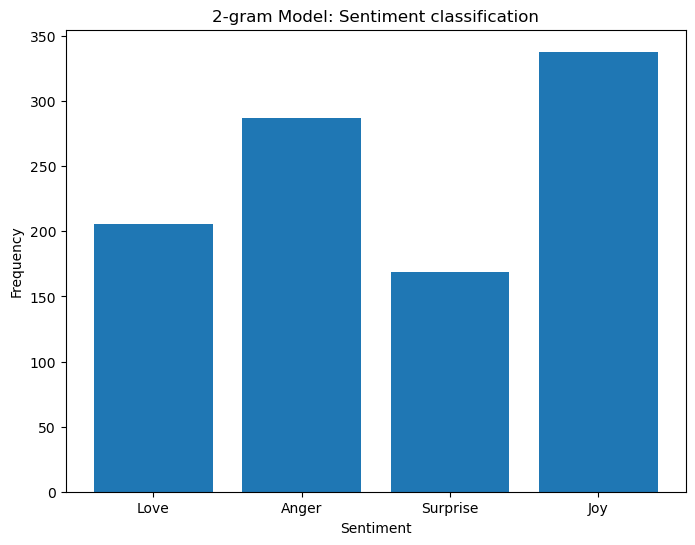

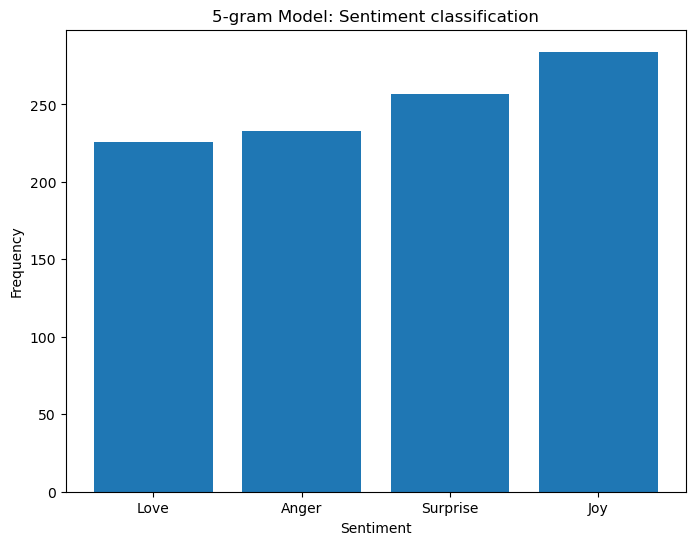

In [7]:
import numpy as np

def preprocess02(doc):
    tokens = reg_tokenizer.tokenize(doc.lower())
    return tokens

preprocessed02_corpus = undersampled_emotions_df['text'].apply(preprocess02)
tokenized_sentences = preprocessed02_corpus.tolist()

train_2gram, vocabulary_2gram = padded_everygram_pipeline(2, tokenized_sentences)
train_5gram, vocabulary_5gram = padded_everygram_pipeline(5, tokenized_sentences)

MLE_2gram = MLE(2)
MLE_5gram = MLE(5)

MLE_2gram.fit(train_2gram, vocabulary_2gram)
MLE_5gram.fit(train_5gram, vocabulary_5gram)

def generate_text(model, n, length=50): #function to generate text, the length=50 is randomly chosen.
    content = []
    token = model.generate(text_seed=["<s>"])  #start with a seed token
    for i in range(length):
        if token == '</s>': #i check if the token generated is the sentense ending token, then the loop breaks for efficiency.
            break
        content.append(token)
        token = model.generate(text_seed=content[-n:])  #use the last n tokens as the seed for the next token
    return ' '.join(content)

document_2gram = generate_text(MLE_2gram, n=2)
document_5gram = generate_text(MLE_5gram, n=5)

print("Generated Document (2-gram):", document_2gram)
print("Generated Document (5-gram):", document_5gram)

# using CountVectorizer to vectorize the generated text
bow_matrix02 = vectorizer.transform([document_2gram, document_5gram])

predicted_labels = classifier.predict(bow_matrix02)  # using our pre-trained classifier
print("The predicted labels are:", predicted_labels)


n_documents = 1000
generated_documents_2gram = [generate_text(MLE_2gram, n=2) for i in range(n_documents)]
bow_matrix1000_2gram = vectorizer.transform(generated_documents_2gram)
predicted_labels1000_2gram = classifier.predict(bow_matrix1000_2gram)


plt.figure(figsize=(8, 6))
plt.hist(predicted_labels1000_2gram, bins=np.arange(len(set(predicted_labels1000_2gram)) + 1) - 0.5, rwidth=0.8)
plt.title("2-gram Model: Sentiment classification")
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.xticks(ticks=range(len(set(predicted_labels1000_2gram))), labels=set(predicted_labels1000_2gram))
plt.savefig('2-gram Model: Sentiment classification.png', format='png')
plt.show()

generated_documents_5gram = [generate_text(MLE_5gram, n=5) for i in range(n_documents)]
bow_matrix1000_5gram = vectorizer.transform(generated_documents_5gram)
predicted_labels1000_5gram = classifier.predict(bow_matrix1000_5gram)

plt.figure(figsize=(8, 6))
plt.hist(predicted_labels1000_5gram, bins=np.arange(len(set(predicted_labels1000_5gram)) + 1) - 0.5, rwidth=0.8)
plt.title("5-gram Model: Sentiment classification")
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.xticks(ticks=range(len(set(predicted_labels1000_5gram))), labels=set(predicted_labels1000_5gram))
plt.savefig('5-gram Model: Sentiment classification.png', format='png')
plt.show()

## Word2Vec

In [8]:
tokenized_corpus = preprocessed02_corpus

W2V_model = Word2Vec(sentences = tokenized_corpus, vector_size=25, window=5, min_count=3, workers=4, sg=1)
W2V_model.train(tokenized_corpus, total_examples = len(tokenized_corpus), epochs = 50)

#Checking the vector embedding for 'christmas'

if 'christmas' in W2V_model.wv:
    christmas_vector = W2V_model.wv['christmas']
    print("Embedding for 'christmas':", christmas_vector)
else:
    print("'christmas' is not in the vocabulary.")


Embedding for 'christmas': [ 0.78372943  0.00689264  0.42173877  0.08934157 -0.28178677  0.63633996
  0.57729787  0.7890684  -0.41752025 -0.19123611  0.319957   -0.23366988
 -0.42494842 -0.08883049 -1.0772023   0.09982216 -0.12420698  0.49110383
 -1.025018    0.11123461 -0.0554118   0.2971573  -0.25197124  0.36581355
  0.7583174 ]


In [9]:
from numpy.linalg import norm
import numpy as np

#without using the most_similar method, finding the top 3 most similar and dissimilar words to 'christmas'

all_similarities = {}
for word in W2V_model.wv.key_to_index.keys(): #calculating the cosine similarity of each word from the vocabulary and then saving it in the dictionary 'all_similarities'
    if word != 'christmas':
        similarity = np.dot(W2V_model.wv[word], W2V_model.wv['christmas'])/(norm(W2V_model.wv[word])*norm( W2V_model.wv['christmas'])) #dot product of the 2 vectors divided by the product of their magnitudes
        all_similarities[word] = similarity

top3_most_similar = sorted(all_similarities.items(), key = lambda item: item[1], reverse = True)[:3]
top3_most_dissimilar = sorted(all_similarities.items(), key = lambda item: item[1], reverse = False)[:3]

print("The top 3 most similar words to 'christmas' and their respective similarities are:")
for word, similarity in top3_most_similar:
    print(f'{word}; {similarity:.3f}')
    
print("The top 3 most dissimilar words to 'christmas' and their respective similarities are:")
for word, similarity in top3_most_dissimilar:
    print(f'{word}; {similarity:.3f}')

The top 3 most similar words to 'christmas' and their respective similarities are:
holiday; 0.897
thanksgiving; 0.832
carols; 0.815
The top 3 most dissimilar words to 'christmas' and their respective similarities are:
arrogant; -0.299
harm; -0.273
accusing; -0.269


In [10]:
#By using the 'most_similar' method, finding the top 3 most similar and dissimilar words to 'christmas'

top3_sims = W2V_model.wv.most_similar(positive = 'christmas', topn=3)
top3_dissims = sims = W2V_model.wv.most_similar(negative = 'christmas', topn=3)

print("The top 3 most similar words to 'christmas' and their respective similarities are:")
for word, similarity in top3_sims:
    print(f'{word}; {similarity:.3f}')
    
print("The top 3 most dissimilar words to 'christmas' and their respective similarities are:")
for word, similarity in top3_dissims:
    print(f'{word}; {similarity:.3f}')

'''
We note that using the 'most_similar' method gives us positive cosine similarities for the most dissimilar words,
compared to what we did in the previous cell where we just calculated the cosine similarities by taking the dot product
of each word vector with the 'christmas' vector and then dividing that by the product of their magnitudes. The negative sign indicates
that the vectors form an angle greater than 90 degrees.

'''

The top 3 most similar words to 'christmas' and their respective similarities are:
holiday; 0.897
thanksgiving; 0.832
carols; 0.815
The top 3 most dissimilar words to 'christmas' and their respective similarities are:
arrogant; 0.299
harm; 0.273
accusing; 0.269


"\nWe note that using the 'most_similar' method gives us positive cosine similarities for the most dissimilar words,\ncompared to what we did in the previous cell where we just calculated the cosine similarities by taking the dot product\nof each word vector with the 'christmas' vector and then dividing that by the product of their magnitudes. The negative sign indicates\nthat the vectors form an angle greater than 90 degrees.\n\n"

In [12]:
emotions_related_to_christmas01 = W2V_model.wv.most_similar(positive = ['christmas', 'emotion'], topn=5)
emotions_related_to_christmas02 = W2V_model.wv.most_similar(positive = ['christmas'], negative = ['emotion'], topn=5)
emotions_related_to_christmas03 = W2V_model.wv.most_similar(positive = ['emotion'], negative = ['christmas'], topn=5)
emotions_related_to_christmas04 = W2V_model.wv.most_similar(negative = ['emotion', 'christmas'], topn=5)

print("The top 5 words related to the keywords: positive=['christmas', 'emotion']")
for word, similarity in emotions_related_to_christmas01:
    print(f'{word}; {similarity:.3f}')
    
print("The top 5 words related to the keywords: positive=['christmas'], negative = ['emotion']")
for word, similarity in emotions_related_to_christmas02:
    print(f'{word}; {similarity:.3f}')
    
print("The top 5 words related to the keywords: positive=['emotion'], negative = ['christmas']")
for word, similarity in emotions_related_to_christmas03:
    print(f'{word}; {similarity:.3f}')
    
print("The top 5 words related to the keywords: negative=['christmas', 'emotion']")
for word, similarity in emotions_related_to_christmas04:
    print(f'{word}; {similarity:.3f}')

The top 5 words related to the keywords: positive=['christmas', 'emotion']
excitement; 0.846
gratitude; 0.801
enormity; 0.799
joy; 0.796
lows; 0.784
The top 5 words related to the keywords: positive=['christmas'], negative = ['emotion']
shop; 0.626
hunt; 0.609
carols; 0.609
gal; 0.590
holiday; 0.590
The top 5 words related to the keywords: positive=['emotion'], negative = ['christmas']
expression; 0.670
reaction; 0.648
inducing; 0.647
hatred; 0.633
suppression; 0.620
The top 5 words related to the keywords: negative=['christmas', 'emotion']
punching; 0.048
conservative; 0.042
political; 0.041
crossed; 0.037
scars; 0.032
